# Rosenbrock function - One constraint

### Written by José Hugo Elsas, Tecgraf (PUC-Rio), BR.

*Last updated Monday, 6 May 2019.*

This is a GPyOpt contrained optimization example for the [Rosenbrock function with a disk constraint](https://en.wikipedia.org/wiki/Test_functions_for_optimization). The global minimum is:

$f(1.0,1.0) = 0.0$

The important imports are the [GPy](https://sheffieldml.github.io/GPy/) and [GPyOpt](https://github.com/SheffieldML/GPyOpt) libraries, and the initial_design function to select the first points to initialize the method. This function requires dealing with constraint, which is done using the acquisition function of [Expected Improvement](https://www.researchgate.net/publication/248818761_The_application_of_Bayesian_methods_for_seeking_the_extremum) (EI) with [Probability of Feasibility](https://dl.acm.org/citation.cfm?id=3044997) (PoF). For references of Probability of Feasibility, read [Gardner et. al. (2014)](https://stat.columbia.edu/~cunningham/pdf/GardnerICML2014.pdf), [Gelbart (2015)](https://dash.harvard.edu/bitstream/handle/1/17467236/GELBART-DISSERTATION-2015.pdf?sequence=4&isAllowed=y) and [Schonlau (2015)](https://www.collectionscanada.gc.ca/obj/s4/f2/dsk3/ftp04/nq22234.pdf). A modified version of the Bayesian Optimization method is required, named ModularConstrainedBayesianOptimization.

In [1]:
%pylab inline
import GPy
import GPyOpt
import numpy as np
import matplotlib.pyplot as plt
from GPyOpt.experiment_design import initial_design
from GPyOpt.acquisitions.EI import AcquisitionEI
from GPyOpt.methods import ModularBayesianOptimization

Populating the interactive namespace from numpy and matplotlib


The definition of the Rosenbrock function with the disk constraint, is given by the functions below:

In [2]:
def rosenbrock(x,y):
    return ((1.0-x)**2+100*((y-x**2)**2))

def disk_contraint(x,y):
    return (2.-(x**2)-(y**2))

Create (xv,yv) variables to be able to plot and visualize the function in 2D and 3D

In [3]:
X_ax = np.linspace(-1.5,1.5,201)
Y_ax = np.linspace(-1.5,1.5,201)

v_rosenbrock = np.vectorize(rosenbrock)

xv, yv = np.meshgrid(X_ax, Y_ax, sparse=False, indexing='ij')

zv = np.zeros(xv.shape)

for i in range(X_ax.shape[0]):
    for j in range(Y_ax.shape[0]):
        g = disk_contraint(X_ax[i],Y_ax[j])
        if(g>=0):
            zv[i,j] = rosenbrock(X_ax[i],Y_ax[j])
        else:
            zv[i,j] = np.nan

To the left, the 2D heatmap plot of the Rosenbrock function, and to the right, a 3D rendering of the same function. There is one global minimum, which correspond to the tip of the beak at $(1.0,1.0)$.

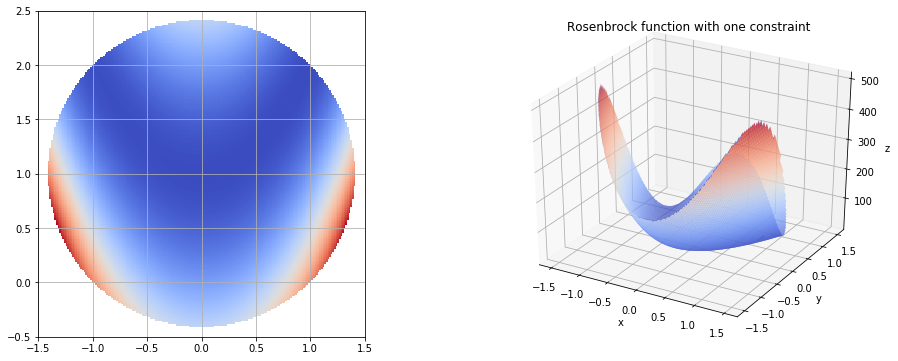

In [4]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(1,2,1)
ax.set_aspect('equal')
ax.grid()
ax.imshow(zv.T,cmap=cm.coolwarm,extent=(-1.5,1.5,-0.5,2.5),origin='bottom')

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot_surface(xv, yv, zv, rstride=1, cstride=1,
                cmap=cm.coolwarm, edgecolor='none',
                vmin = 0, vmax = 500)

ax2.set_title('Rosenbrock function with one constraint');
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
plt.show()

The search space of the optimization problem is the box $[-1.5,1.5] \times [-1.5,1.5]$, with continuous variables.

There are two GP models: One for interpolating the objective function, and another for interpolating the constraint. In this case the constraint is very simple,but it might not be the case in other problems.

The acquisition function is the Expected Improvement with Probability of Feasibility extension, named AcquisitionEI_PoF. The evaluator is the standard serial evaluator. jitter is set to $10^{-5}$

The initial choice of points is done via the initial_design function, according to a random sampling. The objective function and the constraints are evaluated on those points before the Bayesian optimization loop. 

In [14]:
np.set_printoptions(precision=6)

objective = None 
constraint = None

space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-1.5,1.5)},
        {'name': 'var_2', 'type': 'continuous', 'domain': (-1.5,1.5)}]
space = GPyOpt.Design_space(space = space)

kernel   = None 
kernel_c = None

model    = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c1 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c  = [model_c1]

aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

acquisition = AcquisitionEI(model,space,optimizer=aquisition_optimizer,jitter=1.0,model_c=model_c,jitter_c=[0.0])

# --- CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

num_init = 20
typ_init = 'random'
X_init = initial_design(typ_init,space,num_init)

Y_init = np.zeros((X_init.shape[0],1))
C_init = np.zeros((X_init.shape[0],1))

for i in range(num_init):
    Y_init[i,0] = rosenbrock(X_init[i,0],X_init[i,1])
    C_init[i,0] = disk_contraint(X_init[i,0],X_init[i,1])
    
print(np.hstack((X_init,Y_init,C_init)))

[[ 1.804080e-01  1.658414e-01  2.448470e+00  1.939950e+00]
 [-1.273413e+00 -9.449126e-03  2.711940e+02  3.783308e-01]
 [-1.490709e+00  1.445995e+00  6.645516e+01 -2.313115e+00]
 [-1.288975e+00 -3.515315e-02  2.930876e+02  3.373086e-01]
 [ 1.258564e+00  7.720377e-01  6.599259e+01 -1.800266e-01]
 [ 7.393448e-01 -8.081776e-01  1.836185e+02  8.002182e-01]
 [ 3.272335e-01 -1.087182e+00  1.430792e+02  7.109537e-01]
 [ 5.529595e-01 -1.309068e+00  2.609682e+02 -1.942389e-02]
 [ 1.161068e-01  1.360417e-01  2.283386e+00  1.968012e+00]
 [-9.333678e-01 -1.404142e+00  5.214449e+02 -8.427908e-01]
 [ 9.895689e-01  6.357974e-01  1.179585e+01  6.165150e-01]
 [ 1.349837e-02  1.761616e-01  4.070060e+00  1.968785e+00]
 [ 9.622877e-01  1.413613e+00  2.377828e+01 -9.242987e-01]
 [ 8.251439e-01  6.010645e-01  6.673462e-01  9.578591e-01]
 [-8.102951e-01 -2.440750e-01  8.439479e+01  1.283849e+00]
 [-8.539250e-01 -1.356267e+00  4.383491e+02 -5.686475e-01]
 [ 8.813447e-04 -7.650972e-01  5.953573e+01  1.414626e+0

The main external loop is executed using the ModularConstrainedBayesianOptimization object, initialized with the interpolation method of usual Gaussian Process, the acquisition function is the Expected Improvement w/ PoF, and default jitter used for a standard Bayesian Optimization loop.

In [15]:
iter_count = 150-num_init
current_iter = 0
X_step = X_init
Y_step = Y_init
C_step = C_init 

while current_iter < iter_count:
    bo_step = ModularBayesianOptimization(model, space, objective, acquisition, evaluator, 
                                          X_init = X_step, Y_init = Y_step, C_init = C_step, 
                                          model_c = model_c, normalize_Y = False)
    
    x_next = bo_step.suggest_next_locations()
    y_next = np.array(rosenbrock(x_next[0][0],x_next[0][1]))
    c_next = np.array(disk_contraint(x_next[0][0],x_next[0][1]))
    print("Current iteration - ",current_iter," : ",np.hstack([x_next[0],y_next,c_next]))
    
    X_step = np.vstack((X_step, x_next))
    Y_step = np.vstack((Y_step, y_next))
    C_step = np.vstack((C_step, c_next))
    
    current_iter += 1

Current iteration -  0  :  [0.958894 1.038678 1.422555 0.00167 ]
Current iteration -  1  :  [4.984939e-01 1.297969e+00 1.103909e+02 6.677959e-02]
Current iteration -  2  :  [ 0.805297  1.146516 24.839536  0.036998]
Current iteration -  3  :  [6.196945e-01 1.257740e+00 7.648301e+01 3.406978e-02]
Current iteration -  4  :  [1.076583 0.910097 6.202653 0.012694]
Current iteration -  5  :  [ 0.752962  1.148033 33.826531  0.115067]
Current iteration -  6  :  [0.934343 1.008459 1.839303 0.110014]
Current iteration -  7  :  [8.679416e-01 1.114848e+00 1.308752e+01 3.790892e-03]
Current iteration -  8  :  [5.913059e-01 1.260229e+00 8.308375e+01 6.218065e-02]
Current iteration -  9  :  [0.914058 1.072166 5.608384 0.014959]
Current iteration -  10  :  [7.824495e-01 1.177412e+00 3.199076e+01 1.472734e-03]
Current iteration -  11  :  [ 0.783778  1.120872 25.707577  0.129338]
Current iteration -  12  :  [7.674975e-01 1.174989e+00 3.438618e+01 3.034949e-02]
Current iteration -  13  :  [0.984567 1.0083

Current iteration -  111  :  [0.859948 0.769769 0.111171 0.667946]
Current iteration -  112  :  [0.761226 0.612974 0.169295 1.044797]
Current iteration -  113  :  [0.430831 0.175197 0.334807 1.78369 ]
Current iteration -  114  :  [0.588833 0.346852 0.16906  1.532969]
Current iteration -  115  :  [0.884057 0.807162 0.079009 0.566932]
Current iteration -  116  :  [0.750018 0.593061 0.155724 1.085751]
Current iteration -  117  :  [0.381729 0.131834 0.401533 1.836903]
Current iteration -  118  :  [0.888665 0.814208 0.072338 0.547339]
Current iteration -  119  :  [0.594139 0.353611 0.16476  1.521958]
Current iteration -  120  :  [0.747781 0.588045 0.14695  1.095026]
Current iteration -  121  :  [0.349858 0.10665  0.447494 1.866225]
Current iteration -  122  :  [0.541771 0.290685 0.210775 1.621987]
Current iteration -  123  :  [0.688429 0.490314 0.123905 1.285658]
Current iteration -  124  :  [0.891276 0.818221 0.068695 0.536143]
Current iteration -  125  :  [0.803327 0.676789 0.137618 0.896

Summary of the improvement of the best found point.

In [16]:
X_val = X_step[np.all(C_step>=0,axis=1)]
Y_val = Y_step[np.all(C_step>=0,axis=1)]
C_val = C_step[np.all(C_step>=0,axis=1)]

A_val = np.hstack((X_val,Y_val,C_val))

T = 20.0
print(np.argwhere(A_val[:,2]<T)[0,0],X_val[np.argwhere(A_val[:,2]<T)[0,0]],Y_val[np.argwhere(A_val[:,2]<T)[0,0]])
T = 10.0
print(np.argwhere(A_val[:,2]<T)[0,0],X_val[np.argwhere(A_val[:,2]<T)[0,0]],Y_val[np.argwhere(A_val[:,2]<T)[0,0]])
T = 5.0
print(np.argwhere(A_val[:,2]<T)[0,0],X_val[np.argwhere(A_val[:,2]<T)[0,0]],Y_val[np.argwhere(A_val[:,2]<T)[0,0]])
T = 1.0
print(np.argwhere(A_val[:,2]<T)[0,0],X_val[np.argwhere(A_val[:,2]<T)[0,0]],Y_val[np.argwhere(A_val[:,2]<T)[0,0]])
T = 0.5
print(np.argwhere(A_val[:,2]<T)[0,0],X_val[np.argwhere(A_val[:,2]<T)[0,0]],Y_val[np.argwhere(A_val[:,2]<T)[0,0]])
print(np.argmin(Y_val,axis=0)[0],X_val[np.argmin(Y_val,axis=0)][0],Y_val[np.argmin(Y_val,axis=0)][0])

0 [0.180408 0.165841] [2.44847]
0 [0.180408 0.165841] [2.44847]
0 [0.180408 0.165841] [2.44847]
8 [0.825144 0.601064] [0.667346]
27 [0.984567 1.008352] [0.152174]
104 [0.920748 0.847913] [0.006283]


Summary of the optimization: 

In [17]:
print("Point step where minimium was found: ",np.argmin(Y_step))
print("Exact Global minima: ")
print(np.array([1.0,1.0,0.0]))
print("Global minima found: ")
print(np.hstack((X_step[Y_step[:,0]<0.3,:],Y_step[Y_step<0.3][:,np.newaxis])))

Point step where minimium was found:  110
Exact Global minima: 
[1. 1. 0.]
Global minima found: 
[[0.984567 1.008352 0.152174]
 [1.00854  0.98151  0.127112]
 [0.972963 0.998415 0.268629]
 [0.981632 1.017221 0.287839]
 [0.865776 0.748884 0.018063]
 [0.557012 0.33746  0.270205]
 [0.920748 0.847913 0.006283]
 [0.484272 0.230443 0.267637]
 [0.714624 0.536213 0.146598]
 [0.855704 0.765348 0.130504]
 [0.857309 0.766609 0.120407]
 [0.859948 0.769769 0.111171]
 [0.761226 0.612974 0.169295]
 [0.588833 0.346852 0.16906 ]
 [0.884057 0.807162 0.079009]
 [0.750018 0.593061 0.155724]
 [0.888665 0.814208 0.072338]
 [0.594139 0.353611 0.16476 ]
 [0.747781 0.588045 0.14695 ]
 [0.541771 0.290685 0.210775]
 [0.688429 0.490314 0.123905]
 [0.891276 0.818221 0.068695]
 [0.803327 0.676789 0.137618]
 [0.487095 0.232194 0.265639]
 [0.655213 0.43708  0.124925]
 [0.898207 0.82927  0.060956]]


Plotting the heatmap of the Rosenbrock function against the scatterplot of the queried points, one obtains the picture below:

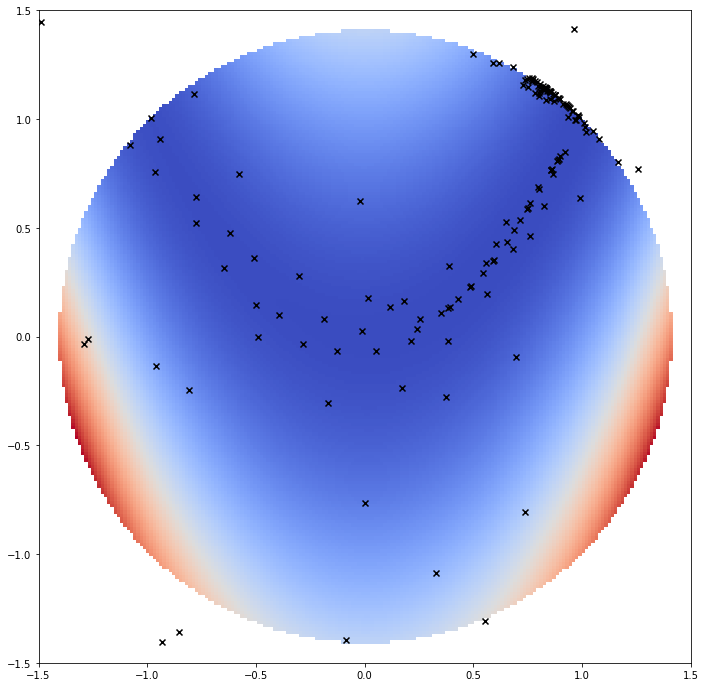

In [18]:
fig = plt.figure(figsize = (12,12))
ax.set_aspect('equal')

plt.imshow(zv.T,cmap=cm.coolwarm,extent=(-1.5,1.5,-1.5,1.5),origin='bottom')
plt.scatter(X_step[:,0],X_step[:,1],marker='x',color='black')

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

plt.show()

Creating a series of .jpg files so one can create a gif with the dynamic visualization of the Bayesian Optimization loop:

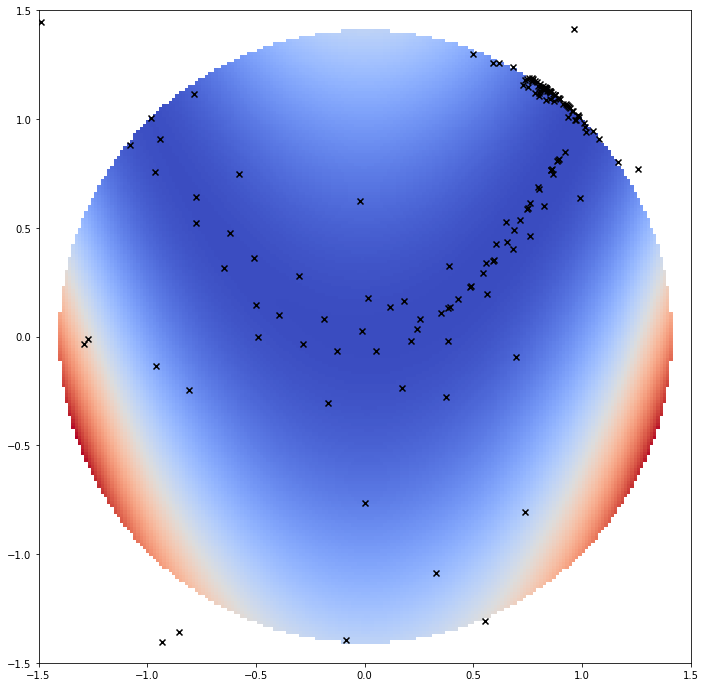

In [20]:
import os

if(not os.path.exists("gif")):
    os.mkdir("gif")

fig = plt.figure(figsize = (12,12))
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))
for n in range(iter_count):
    fig.clf()
    plt.xlim((-1.5,1.5))
    plt.ylim((-1.5,1.5))
    plt.imshow(zv.T,cmap=cm.coolwarm,aspect ='equal',origin='lower',extent=(-1.5,1.5,-1.5,1.5))
    plt.scatter(X_step[0:(n+num_init),0],X_step[0:(n+num_init),1],c='black',marker='x')
    plt.savefig("gif/BO_Rosenbrock-MC1-"+str(n)+"-("+typ_init+","+str(num_init)+").png", bbox_inches='tight')